In [ ]:
%tensorflow_version 1.x
!pip3 uninstall -y keras
!pip3 install keras==2.1.0
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

ROOT_DIR = os.path.abspath("../")

sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

TensorFlow 1.x selected.
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 307kB 17.5MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.91 MiB/s, done.
Resolving deltas: 100% (561/561), done.
/content/Mask_RCNN
     |████████████████████████████████| 163kB 17.9MB/s 
     |████████████████████████████████| 204kB 36.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1c78914c2e12efd5dc2806bb35a9c155ca05bfb70143aa1ce1eb776158abc710
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfu

Using TensorFlow backend.


... done downloading pretrained model!


In [2]:
class FoodcontrollerConfig(Config):
    NAME = "Foodcontroller_segmentation"
    # 1+(幾類)
    NUM_CLASSES = 1 + 9

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = FoodcontrollerConfig()
config.display()
print(os.getcwd())


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
class FoodDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'Bitter_gourd')
        self.add_class('dataset', 2, 'Cabbage')
        self.add_class('dataset', 3, 'Potato')
        self.add_class('dataset', 4, 'Cucumber')
        self.add_class('dataset', 5, 'Cucumber_chips')
        self.add_class('dataset', 6, 'Garlic')
        self.add_class('dataset', 7, 'Chinese_cabbage')
        self.add_class('dataset', 8, 'Corn')
        self.add_class('dataset', 9, 'Onion')
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.jpg' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.jpg', '.json')))
    
    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)
            
        masks = np.zeros([300, 400, len(img_anns['shapes'])], dtype='uint8')
        classes = []
        for i, anno in enumerate(img_anns['shapes']):
            mask = np.zeros([300, 400], dtype=np.uint8)
            cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
            masks[:, :, i] = mask
            classes.append(self.class_names.index(anno['label']))
        return masks, classes
 
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [4]:
dataset_train = FoodDataset()
dataset_train.load_dataset('/content/Mask_RCNN/train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
dataset_val = FoodDataset()
dataset_val.load_dataset('/content/Mask_RCNN/test')
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))

Train: 248
Test: 141


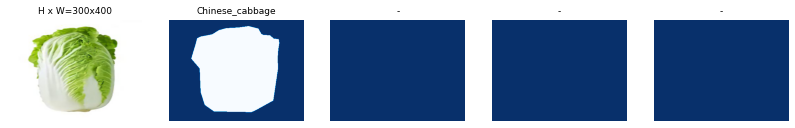

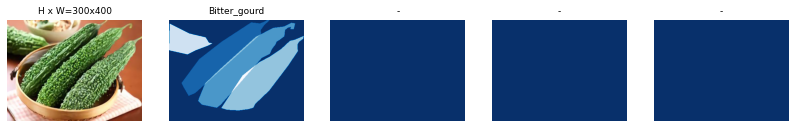

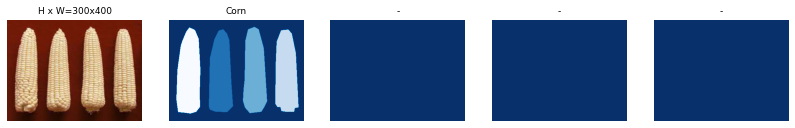

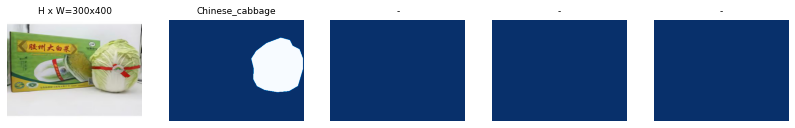

In [5]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [7]:
init_with = "coco"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

In [8]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/foodcontroller_segmentation20210209T1313/mask_rcnn_foodcontroller_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4      

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/2
 999/1000 [============================>.] - ETA: 0s - loss: 1.1826 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.3242

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



1000/1000 [==============================] - 629s 629ms/step - loss: 1.1826 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2690 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.3465 - mrcnn_mask_loss: 0.3242 - val_loss: 1.1733 - val_rpn_class_loss: 0.0165 - val_rpn_bbox_loss: 0.3361 - val_mrcnn_class_loss: 0.2315 - val_mrcnn_bbox_loss: 0.3165 - val_mrcnn_mask_loss: 0.2726
Epoch 2/2
1000/1000 [==============================] - 560s 560ms/step - loss: 0.6984 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1753 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.2318 - val_loss: 0.9547 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.2988 - val_mrcnn_class_loss: 0.1343 - val_mrcnn_bbox_loss: 0.2465 - val_mrcnn_mask_loss: 0.2634


In [9]:
model.keras_model.save_weights('trainV1.h5')


In [10]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 2. LR=0.0001

Checkpoint Path: /content/logs/foodcontroller_segmentation20210209T1313/mask_rcnn_foodcontroller_segmentation_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

In [11]:
model.keras_model.save_weights('trainV1_1.h5')


In [12]:
class InferenceConfig(FoodcontrollerConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/logs/foodcontroller_segmentation20210209T1313/mask_rcnn_foodcontroller_segmentation_0002.h5
Re-starting from epoch 2


In [13]:
def get_ax(rows=1, cols=1, size=8):

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    8.00000  max:    8.00000  int32
gt_bbox                  shape: (1, 4)                min:  189.00000  max:  686.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


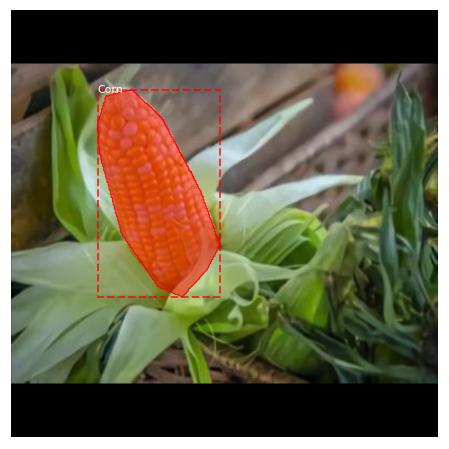

In [56]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


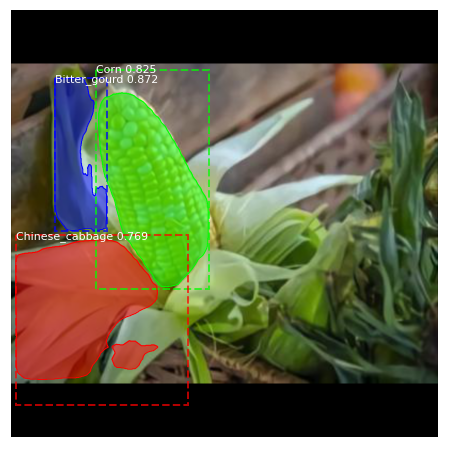

In [57]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [22]:
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = model.detect([image], verbose=0)
    r = results[0]
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.5868638885736828
